In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
import shutil
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from pathlib import Path

from tqdm.notebook import tqdm
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.filterwarnings(action='ignore')

# np.random.seed(42)
random.seed(42)
np.random.seed(42)
# os.environ["PYTHONHASHSEED"] = str(42)
# os.environ['TF_DETERMINISTIC_OPS'] = str(42)
tf.random.set_seed(1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

252911616/252907541 [==============================] - 8s 0us/step


In [2]:
p_cwd = Path('.')
ROOTPATH = p_cwd.cwd()
train_annotation_file = ROOTPATH / 'annotations' / 'captions_train2017.json'
test_annotation_file = ROOTPATH / 'annotations' / 'captions_val2017.json'
train_PATH = ROOTPATH / 'train2017'


In [3]:
# annotation 로드
with open(train_annotation_file, 'r') as f:
    annotations = json.load(f)

image_path_to_caption = collections.defaultdict(list) #다운로드 받은 이미지_캡션 데이터
for val in annotations['annotations']:
  image_path = f"{str(train_PATH)}/{val['image_id']:012}.jpg" # 12자리로 앞부터 0으로 패딩
  caption = f"<start> {val['caption']} <end>"
  # print(val['image_id'], v, caption) 

  # key: image_path, value: cation, 하나의 이미지에 caption 여러개
  image_path_to_caption[image_path].append(caption)

In [4]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths) #이미지 섞기

debug = True
# 체크포인트 삭제
if debug:
  if os.path.isdir('./checkpoints'):
    shutil.rmtree('./checkpoints')
### 빠르게 돌려보기 위해서 학습셋 제한
if debug:
  # train_image_paths = image_paths[:10000]
  train_image_paths = image_paths
  print(len(train_image_paths)) # 5천개만
else :
  train_image_paths = image_paths
  print(len(train_image_paths)) #총 이미지의 개수 11만개

118287


In [5]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  # 이미지에 매칭된 캡션을 flat list로 쭉 펴줌
  train_captions.extend(caption_list) 
  # train_captions과 동일한 index에 동일한 image 이름이 올 수 있도록 이미지당 캡션의 수만큼 extend
  img_name_vector.extend([image_path] * len(caption_list)) 

In [9]:
# coco data 공식적으로는 이미지당 5개 caption이지만, 아닌것들도 있음
err = [image_path_to_caption[k] for k in image_path_to_caption.keys() if len(image_path_to_caption[k])!= 5]
len(err)

315

In [10]:
def load_image(image_path):
  '''
  return (229,299,3), image_path
  img를 불러와서 inceptionV3에 넣기위해 
  최소 전처리(이미지 size변경, preprocess_input 수행)
  '''
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# (299,299,3)의 이미지를 inceptionV3 통과, (8,8,2048) 텐서로 특징 추출
image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 



In [12]:
batch_inceptionV3 = 32

encode_train = sorted(set(img_name_vector))

# from_tensor_slices는 데이터 파이프라인을 만들어주는 함수
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map( # map 함수로 load_image를 적용, batch 32개씩
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_inceptionV3)

for img, path in tqdm(image_dataset): #이미지 데이터 batch data set, batch = 32
  #각 특징값을 잡아서 추출 inception (8,8,2048) 텐서로 특징 추출
  batch_features = image_features_extract_model(img) 

  # (64,2048)의 크기의 텐서로 변환, 2048개의 1차원 feature map
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3])) 
  # print(batch_features.shape)
  for bf, p in zip(batch_features, path):
    # batch data set에 바이너리화 되있는 경로를 decoding후 할당, 원래 경로명으로
    path_of_feature = p.numpy().decode("utf-8") 
    #추출된 데이터들을 저장시킴 # image 경로에 저장됨
    # 전처리와 특징 inceptionV3을 사용하는 특징추출은 1번만 해서 넘파이 파일로 직접 저장
    np.save(path_of_feature, bf.numpy())
    

In [13]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor) 
#가장 길이가 큰 문장에 맞춰 pad를 할당할수있게끔 가장길이가 긴 문장을 찾는 함수

In [15]:
if debug:
  # top_k = 10000
  top_k = 15000
else :
  top_k = 15000#15000개의 단어만을 vocab에서 사용하게끔 함
print(f'number of vocaps: {top_k}')
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
#1d list로 flat해준 문장을 토크나이저를 통하여 학습후
tokenizer.fit_on_texts(train_captions) 
#학습된 토크나이저가 문장 리스트를 seqs형태로 저장시킴
train_seqs = tokenizer.texts_to_sequences(train_captions) 

tokenizer.word_index['<pad>'] = 0 #문장의 길이를 맞추는 PAD를 idx 0에 저장
tokenizer.index_word[0] = '<pad>'
tokenizer.index_word # 0번 index에 <pad>를 넣었음

train_seqs = tokenizer.texts_to_sequences(train_captions)  #토크나이저 벡터 생성

number of vocaps: 15000


In [16]:
# 가중치를 저장하는 데 사용되는 max_length를 계산합니다. 문장의 max 토큰 길이
max_length = calc_max_length(train_seqs) 
max_length

52

In [17]:
# 각 벡터를 캡션의 max_length까지 채 웁니다.
# max_length 값을 제공하지 않으면 pad_sequences가 자동으로 계산합니다.
# pad는 post 뒤를 0으로 채움 idx 0 = <pad> 임을 기억
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') 



In [18]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f) #토크나이저 추출

In [19]:
def train_test_splits(img_name_vector, cap_vector, ratio=0.8):
  '''
  img_name_vector = 이미지 경로리스트
  cap_vector = 이미지 caption 리스트
  위 리스트 사이즈, index는 일치함
  '''
  # train / test split
  img_to_cap_vector = collections.defaultdict(list)
  for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

  img_keys = list(img_to_cap_vector.keys())
  # keys를 셔플
  random.shuffle(img_keys) 

  #훈련셋 80% 테스트셋 20%
  slice_index = int(len(img_keys)*ratio) 
  img_name_train_keys, img_name_val_keys = img_keys[:slice_index] , img_keys[slice_index:]

  img_name_train = []
  cap_train = []
  for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

  img_name_val = []
  cap_val = []
  for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

  return img_name_train, cap_train, img_name_val, cap_val, img_to_cap_vector

img_name_train, cap_train, img_name_val, cap_val, img_to_cap_vector = train_test_splits(img_name_vector, cap_vector)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(473404, 473404, 118349, 118349)

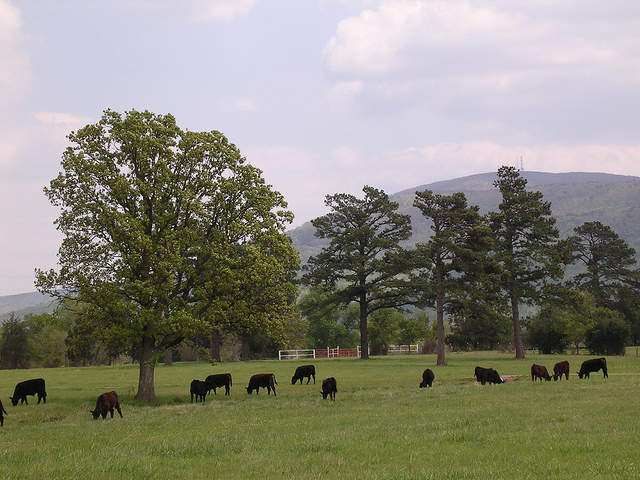

In [22]:
Image.open(img_name_val[50])

In [24]:
BATCH_SIZE = 128 #한번에 네트워크에 넘겨주는 데이터의 수
BUFFER_SIZE = 5000 #고정된 버퍼를 사용하여 항목이 통과할때 순서를 섞는다.
embedding_dim = 256 #임베딩 차원
units = 512 #노드 개수는 512개
vocab_size = top_k + 1 # max 사전크기 +1 개 
num_steps = len(img_name_train) // BATCH_SIZE # 4000 // 64 만큼의 스탭을 반복하여 1epoch의 학습을 진행함
v_num_steps = len(img_name_val) // BATCH_SIZE

#InceptionV3에서 추출한 벡터의 모양은 (64, 2048)
features_shape = 2048 #특징 크기
attention_features_shape = 64 # 주의 해야할 특징 크기

In [25]:
# 위에서 저장해둔 특징값 넘파이를 불러와 저장
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


In [26]:
# 데이터 입력 파이프라인
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# map_func을 불러서, 저장한 특징값 배열을 불러옴
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), 
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
#dataset의 첫번째 값은 img_tensor(특징값),두번째는 caption

# 버퍼사이즈만큼 올려서 랜덤으로 섞고 배치만큼 나눠줌
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# test set도 똑같이해줌
v_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))


v_dataset = v_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# 섞고 배치하기
v_dataset = v_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
v_dataset = v_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [27]:
class BahdanauAttention(tf.keras.Model): 
  # 디코더가 each step마다(t, t+1, ...) 스스로 어떤 벡터에 중점을 둬서 정보를 취할지 선택
  # attention_weights * features를 context vector로 사용
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) #은닉층 출력뉴런 512
    self.W2 = tf.keras.layers.Dense(units) #은닉층 출력뉴런 512
    self.V = tf.keras.layers.Dense(1) #출력층 출력 뉴런 1

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)

    #score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    # attention_hidden_layer=(256,64,512)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    

    score = self.V(attention_hidden_layer) #출력층에서 나오는값

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        #(batch_size, 64, 2048) -> batch_size, 64, 256로
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim) 

    def call(self, x):
        x = self.fc(x) #함수호출시 입력값을 fc를  통해 출력한뒤 
        x = tf.nn.relu(x) #출력값이 0보다 작으면 0으로 0보다크다면 그대로 출력하는 활성화 함수를 통해
        return x #반환한다.

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    # vocab size = hyperparameter, pad포함(+1됨)
    # units = hyperparameter, 512
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) 
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #gru와 LSTM의 성능은 유사하나 속도면에서 차이가큼
    #512
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # print(embedding_dim, units, vocab_size)
    # 어텐션을 별도의 모델로 정의 
    # 1. t 시점의 hidden state와 feature를 사용, attention context_vector를 받음
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x = dec_input, target 문장(토큰화된)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) # 1x256 텐서로 임베딩

    # x shape (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x) #sequences와 state반환

    # shape == (batch_size * max_length, hidden_size)
    x = self.fc1(output) #워드 sequence를 입력하여 x로 반환

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) #x의 형태 변환

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x) #반환

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units)) #초기화시 (1,512)의 텐서로 반환

encoder = CNN_Encoder(embedding_dim) #256 임베딩
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [28]:
## 체크포인트
checkpoint_path = "./checkpoints/final_model1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
@tf.function
def train_step(img_tensor, target): 
  # img_tensor 64x2048 feature map, target은 토큰화된 문장 벡터
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  # (배치크기 X 512)짜리 매트릭스로 0할당 초기화(처음 hidden state)
  hidden = decoder.reset_state(batch_size=target.shape[0]) 

  # <start>토큰을 배치사이즈만큼 준비, 첫번째 decode input
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) 

  with tf.GradientTape() as tape:
      # featuer input (b, 64, 2048) -> (b, 64, 256)
      features = encoder(img_tensor)
      
      # max length 토큰 만큼 반복(max length로 pad되어있기 때문에)
      for i in range(1, target.shape[1]): 
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, # 1번째 dec_input은 <start> 토큰
                                           features, # (b, 64, 256) # inception 통과한것을 fc로 축소한 feature
                                           hidden) # 
          
          # loss function -> predictions단어와 target단어를 비교해서 계산 target은 0이아닌 1부터(<start>토큰 다음)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          # training이니까 일단 prediction에서 정답이 나왔다고(첫 번째 단어 출력을 가정하고, 다음단어 예측하도록)
          dec_input = tf.expand_dims(target[:, i], 1)

  # full로 단어를 다 돌았을 때 평균계산
  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  # loss 나온 것에 대한 train가능한 weight들의 gradient계산
  gradients = tape.gradient(loss, trainable_variables)
  # 옵티마이저로 적용
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [30]:
## gradiant 업데이트 부분 제거한 validation 부분
def loss_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss

In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
v_loss_plot = []
blue_score_plot = []
cosin_score_plot = []

In [32]:
def copy_checkpoint_local():

  src = [str(f) for f in (p_cwd.cwd() / 'checkpoints' / 'final_model1').iterdir()]
  des = [str(f).replace('/content','/content/drive/MyDrive') 
        for f in (p_cwd.cwd() / 'checkpoints' / 'final_model1').iterdir()] 

  if not os.path.isdir('/content/drive/MyDrive/checkpoints/final_model1'):
    os.mkdir('/content/drive/MyDrive/checkpoints')
    os.mkdir('/content/drive/MyDrive/checkpoints/final_model1')

  for s, d in zip(src, des):
    # print(d)
    if not os.path.exists(d):
      # print(s,d)
      shutil.copy(s,d)


In [33]:
def evaluate(image): 
  # validation set에 있는 image 하나
  # 실제 출력되는 caption을 얻어보기 위한 함수
  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0) #image 로드 (299,299,3)
  # image_features_extract_model = tf.keras.Model(new_input, hidden_layer) 
  # inception으로 추출 -> (8,8,2048)
  img_tensor_val = image_features_extract_model(temp_input)

  #CNN에 넣기전 특징값 모양변경 -> (64,2048)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) 

  features = encoder(img_tensor_val)  # Inception_V3로 추출된 특징값을 encode
  # 첫 번째 decode input <start> 토큰
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) 
  result = []

  # max_length까지 decoder에 연속적으로 투입
  for i in range(max_length):
    #decoder를 통해 결과 반환
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 

    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() #관심을 가져야되는 항목을 추출하는곳 #그래프로 출력

    ## predictions에서 1개 뽑음
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
    # 반환값에 계속하여 해당 관심구역에대한 단어 추가
    result.append(tokenizer.index_word[predicted_id]) 

    if tokenizer.index_word[predicted_id] == '<end>': #만약 관심구역에서 나온 단어가 end라면
        return result, attention_plot #문장과 플롯을 반환
    # <end>토큰이 아니면  predicted_id 다음으로 넘겨서 문장의 길이가 최대를 넘지않을때까지 진행
    dec_input = tf.expand_dims([predicted_id], 0) 

  attention_plot = attention_plot[:len(result), :] #문장의 길이만큼만 그래프 그릴것
  
  return result, attention_plot #반환

In [35]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(13, 13))

  len_result = len(result)
  for i in range(len_result):
      temp_att = np.resize(attention_plot[i], (8, 8))
      grid_size = max(np.ceil(len_result/2), 2)
      ax = fig.add_subplot(grid_size, grid_size, i+1)
      ax.set_title(result[i])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      img = ax.imshow(temp_image)
      ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

# captions on the validation set
def display_attention_caption(rid=50): # 비교를 위해 고정
  # rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i]
                          for i in cap_val[rid] if i not in [0]][1:])
  result, attention_plot = evaluate(image)

  print('Real Caption:', real_caption)
  print('Pred Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)

def learing_curve(loss_plot, v_loss_plot):
  plt.plot(loss_plot, label='train loss')
  plt.plot(v_loss_plot, label='val loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  plt.legend()
  plt.show()

def blue_cos_score(blue_score_plot, cosin_score_plot):
  fig = plt.figure(figsize=(15,5))
  ax = plt.subplot(1,2,1)
  for i in range(4):
    # ax = plt.subplot(1,3,i)
    if i < 3:
      labels = f'{i+1}-gram score'
    else :
      labels = f'average-gram score'
    plt.plot(np.array(blue_score_plot).T[i], label=labels)
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.title('BLEU Score Plot')
  plt.legend()

  ax = plt.subplot(1,2,2)
  plt.plot(cosin_score_plot, label='Score')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.title('Cosine Similarity')
  # plt.legend()
  plt.show()

In [36]:
def l1_normalize(v): #각 벡터안의 요소값을 모두 더한 것의 크기가 1이 되도록 벡터의 크기를 조절하는 방법
    norm = np.sum(v)
    return v / norm

def score_fuction():

  gram_1 = []
  gram_2 = []
  gram_3 = []
  gram_4 = []
  gram_cum1 = []
  smoothie = SmoothingFunction().method5

  cosin_list=[]

  # for j in tqdm(range(len(img_name_val))):
  for j in tqdm(range(20)):

    image = img_name_val[j]

    # <pad> index 0을 제외, <start><end>토큰도 제외한 정답문장 토큰
    # img_to_cap_vector -> img와 caption이 매핑 
    ref = []
    for doc in img_to_cap_vector[image]:
      tokens = []
      for token in doc:
        if token not in [0,3,4]:
          tokens.append(tokenizer.index_word[token])
      ref.append(tokens) # 1개의 이미지에 5~7개의 caption이 붙어 있음

    candidate, _ = evaluate(image)
    # end 토큰제거, 출력문장
    candidate = candidate[:-1]

    ## blue score 
    bleu_1gram = sentence_bleu(ref,candidate, weights=(1, 0, 0, 0))
    bleu_2gram = sentence_bleu(ref,candidate, weights=(0, 1, 0, 0),smoothing_function=smoothie)
    bleu_3gram = sentence_bleu(ref,candidate, weights=(0, 0, 1, 0),smoothing_function=smoothie)
    bleu_4gram = sentence_bleu(ref,candidate, weights=(0, 0, 0, 1),smoothing_function=smoothie)
    bleu_cum1 = sentence_bleu(ref, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

    gram_1.append(bleu_1gram)
    gram_2.append(bleu_2gram)
    gram_3.append(bleu_3gram)
    gram_4.append(bleu_4gram)
    gram_cum1.append(bleu_cum1)

    # 생성문장을 마지막에 더함
    ref.append(candidate[:-1])
    doc_line = [' '.join(doc) for doc in ref]
    # tidf table만들고, 코사인 유사도 계산
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(doc_line)
    tfidf_norm_l1 = l1_normalize(tfidf_matrix) # L1 정규화  
    distance_matrix  = cosine_similarity(tfidf_norm_l1.todense())
    # 마지막 문장이 생성된 문장
    cosin = np.mean(distance_matrix[-1])
    cosin_list.append(cosin)

  blue_score = [ np.mean(gram_1),
              np.mean(gram_2),
              np.mean(gram_3),
              np.mean(gram_4),
              np.mean(gram_cum1) ]

  cosin_score = np.mean(cosin_list)

  return blue_score, cosin_score


Train_loss
Epoch 1 Batch 0 Loss 2.1380
Epoch 1 Batch 100 Loss 1.0978
Epoch 1 Batch 200 Loss 1.0121
Epoch 1 Batch 300 Loss 0.8920
Epoch 1 Batch 400 Loss 0.8454
Epoch 1 Batch 500 Loss 0.7475
Epoch 1 Batch 600 Loss 0.7517
Epoch 1 Batch 700 Loss 0.7549
Epoch 1 Batch 800 Loss 0.7466
Epoch 1 Batch 900 Loss 0.7443
Epoch 1 Batch 1000 Loss 0.6964
Epoch 1 Batch 1100 Loss 0.6149
Epoch 1 Batch 1200 Loss 0.7027
Epoch 1 Batch 1300 Loss 0.6741
Epoch 1 Batch 1400 Loss 0.6731
Epoch 1 Batch 1500 Loss 0.6279
Epoch 1 Batch 1600 Loss 0.6532
Epoch 1 Batch 1700 Loss 0.6983
Epoch 1 Batch 1800 Loss 0.7079
Epoch 1 Batch 1900 Loss 0.6740
Epoch 1 Batch 2000 Loss 0.6572
Epoch 1 Batch 2100 Loss 0.6327
Epoch 1 Batch 2200 Loss 0.6522
Epoch 1 Batch 2300 Loss 0.6921
Epoch 1 Batch 2400 Loss 0.6418
Epoch 1 Batch 2500 Loss 0.6169
Epoch 1 Batch 2600 Loss 0.6298
Epoch 1 Batch 2700 Loss 0.6392
Epoch 1 Batch 2800 Loss 0.6063
Epoch 1 Batch 2900 Loss 0.5851
Epoch 1 Batch 3000 Loss 0.6819
Epoch 1 Batch 3100 Loss 0.6069
Epoch 1 B

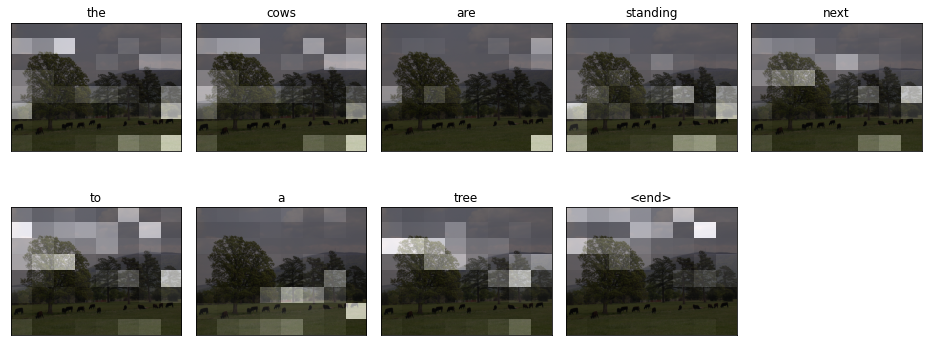


Time taken for eval 5.39 sec

Train_loss
Epoch 4 Batch 0 Loss 0.5707
Epoch 4 Batch 100 Loss 0.5458
Epoch 4 Batch 200 Loss 0.5926
Epoch 4 Batch 300 Loss 0.5560
Epoch 4 Batch 400 Loss 0.5181
Epoch 4 Batch 500 Loss 0.5941
Epoch 4 Batch 600 Loss 0.5270
Epoch 4 Batch 700 Loss 0.5448
Epoch 4 Batch 800 Loss 0.5758
Epoch 4 Batch 900 Loss 0.5299
Epoch 4 Batch 1000 Loss 0.5150
Epoch 4 Batch 1100 Loss 0.5511
Epoch 4 Batch 1200 Loss 0.5535
Epoch 4 Batch 1300 Loss 0.5560
Epoch 4 Batch 1400 Loss 0.5496
Epoch 4 Batch 1500 Loss 0.5186
Epoch 4 Batch 1600 Loss 0.4977
Epoch 4 Batch 1700 Loss 0.5095
Epoch 4 Batch 1800 Loss 0.5207
Epoch 4 Batch 1900 Loss 0.5317
Epoch 4 Batch 2000 Loss 0.5144
Epoch 4 Batch 2100 Loss 0.5368
Epoch 4 Batch 2200 Loss 0.5415
Epoch 4 Batch 2300 Loss 0.5225
Epoch 4 Batch 2400 Loss 0.5531
Epoch 4 Batch 2500 Loss 0.5867
Epoch 4 Batch 2600 Loss 0.5542
Epoch 4 Batch 2700 Loss 0.5552
Epoch 4 Batch 2800 Loss 0.5235
Epoch 4 Batch 2900 Loss 0.5677
Epoch 4 Batch 3000 Loss 0.5687
Epoch 4 B

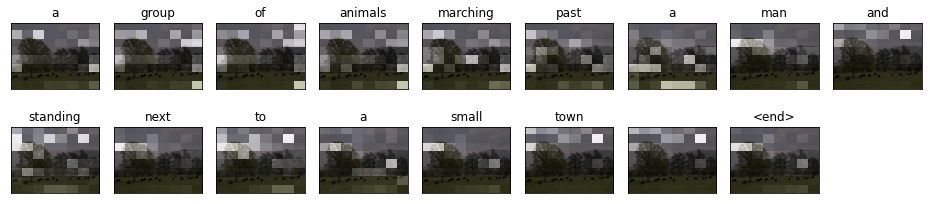


Time taken for eval 5.37 sec

Train_loss
Epoch 6 Batch 0 Loss 0.5333
Epoch 6 Batch 100 Loss 0.5175
Epoch 6 Batch 200 Loss 0.5065
Epoch 6 Batch 300 Loss 0.5385
Epoch 6 Batch 400 Loss 0.5283
Epoch 6 Batch 500 Loss 0.5763
Epoch 6 Batch 600 Loss 0.5188
Epoch 6 Batch 700 Loss 0.5641
Epoch 6 Batch 800 Loss 0.5042
Epoch 6 Batch 900 Loss 0.5302
Epoch 6 Batch 1000 Loss 0.5317
Epoch 6 Batch 1100 Loss 0.5194
Epoch 6 Batch 1200 Loss 0.5290
Epoch 6 Batch 1300 Loss 0.5404
Epoch 6 Batch 1400 Loss 0.5242
Epoch 6 Batch 1500 Loss 0.5138
Epoch 6 Batch 1600 Loss 0.5198
Epoch 6 Batch 1700 Loss 0.5293
Epoch 6 Batch 1800 Loss 0.4888
Epoch 6 Batch 1900 Loss 0.5084
Epoch 6 Batch 2000 Loss 0.5230
Epoch 6 Batch 2100 Loss 0.5528
Epoch 6 Batch 2200 Loss 0.4731
Epoch 6 Batch 2300 Loss 0.5083
Epoch 6 Batch 2400 Loss 0.5206
Epoch 6 Batch 2500 Loss 0.5253
Epoch 6 Batch 2600 Loss 0.5376
Epoch 6 Batch 2700 Loss 0.5431
Epoch 6 Batch 2800 Loss 0.5188
Epoch 6 Batch 2900 Loss 0.5254
Epoch 6 Batch 3000 Loss 0.4825
Epoch 6 B

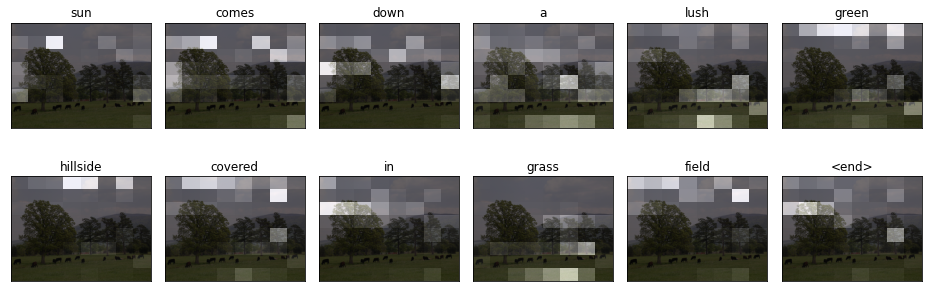


Time taken for eval 5.14 sec

Train_loss
Epoch 8 Batch 0 Loss 0.5093
Epoch 8 Batch 100 Loss 0.5002
Epoch 8 Batch 200 Loss 0.5078
Epoch 8 Batch 300 Loss 0.5097
Epoch 8 Batch 400 Loss 0.5004
Epoch 8 Batch 500 Loss 0.4922
Epoch 8 Batch 600 Loss 0.4894
Epoch 8 Batch 700 Loss 0.4959
Epoch 8 Batch 800 Loss 0.4850
Epoch 8 Batch 900 Loss 0.4995
Epoch 8 Batch 1000 Loss 0.4965
Epoch 8 Batch 1100 Loss 0.4628
Epoch 8 Batch 1200 Loss 0.5141
Epoch 8 Batch 1300 Loss 0.5146
Epoch 8 Batch 1400 Loss 0.5155
Epoch 8 Batch 1500 Loss 0.4868
Epoch 8 Batch 1600 Loss 0.5004
Epoch 8 Batch 1700 Loss 0.5480
Epoch 8 Batch 1800 Loss 0.5328
Epoch 8 Batch 1900 Loss 0.4831
Epoch 8 Batch 2000 Loss 0.4838
Epoch 8 Batch 2100 Loss 0.5299
Epoch 8 Batch 2200 Loss 0.4586
Epoch 8 Batch 2300 Loss 0.4726
Epoch 8 Batch 2400 Loss 0.4805
Epoch 8 Batch 2500 Loss 0.5198
Epoch 8 Batch 2600 Loss 0.4977
Epoch 8 Batch 2700 Loss 0.4806
Epoch 8 Batch 2800 Loss 0.4799
Epoch 8 Batch 2900 Loss 0.4768
Epoch 8 Batch 3000 Loss 0.4836
Epoch 8 B

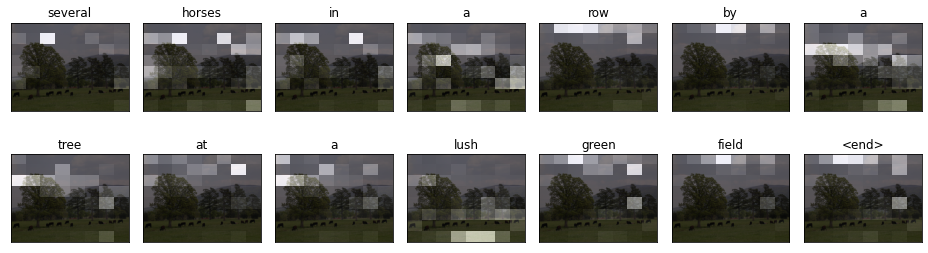


Time taken for eval 5.88 sec

Train_loss
Epoch 10 Batch 0 Loss 0.5074
Epoch 10 Batch 100 Loss 0.4621
Epoch 10 Batch 200 Loss 0.5140
Epoch 10 Batch 300 Loss 0.4958
Epoch 10 Batch 400 Loss 0.4924
Epoch 10 Batch 500 Loss 0.4599
Epoch 10 Batch 600 Loss 0.4986
Epoch 10 Batch 700 Loss 0.5109
Epoch 10 Batch 800 Loss 0.4801
Epoch 10 Batch 900 Loss 0.5061
Epoch 10 Batch 1000 Loss 0.4836
Epoch 10 Batch 1100 Loss 0.4796
Epoch 10 Batch 1200 Loss 0.4783
Epoch 10 Batch 1300 Loss 0.5262
Epoch 10 Batch 1400 Loss 0.4937
Epoch 10 Batch 1500 Loss 0.4838
Epoch 10 Batch 1600 Loss 0.4600
Epoch 10 Batch 1700 Loss 0.5047
Epoch 10 Batch 1800 Loss 0.4815
Epoch 10 Batch 1900 Loss 0.4744
Epoch 10 Batch 2000 Loss 0.4361
Epoch 10 Batch 2100 Loss 0.4820
Epoch 10 Batch 2200 Loss 0.4690
Epoch 10 Batch 2300 Loss 0.5085
Epoch 10 Batch 2400 Loss 0.4846
Epoch 10 Batch 2500 Loss 0.4963
Epoch 10 Batch 2600 Loss 0.4656
Epoch 10 Batch 2700 Loss 0.5119
Epoch 10 Batch 2800 Loss 0.5347
Epoch 10 Batch 2900 Loss 0.5117
Epoch 10 B

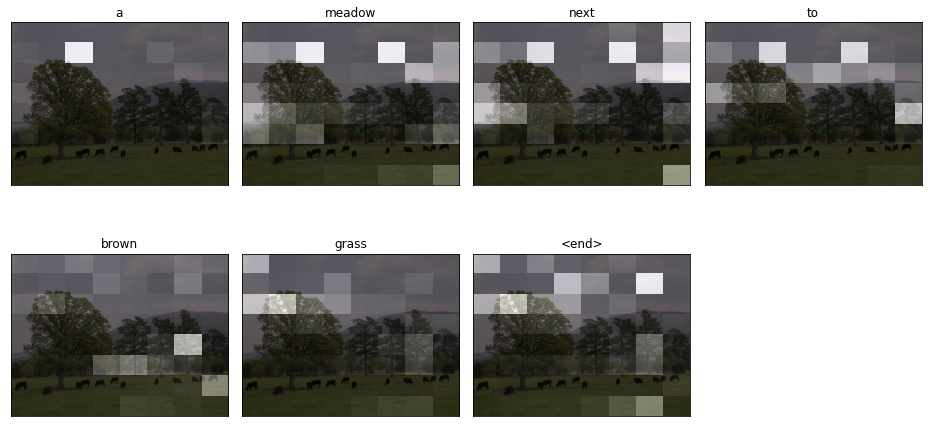


Time taken for eval 6.35 sec

Train_loss
Epoch 12 Batch 0 Loss 0.4962
Epoch 12 Batch 100 Loss 0.4421
Epoch 12 Batch 200 Loss 0.4398
Epoch 12 Batch 300 Loss 0.4599
Epoch 12 Batch 400 Loss 0.4680
Epoch 12 Batch 500 Loss 0.4810
Epoch 12 Batch 600 Loss 0.4757
Epoch 12 Batch 700 Loss 0.4895
Epoch 12 Batch 800 Loss 0.4496
Epoch 12 Batch 900 Loss 0.4826
Epoch 12 Batch 1000 Loss 0.4697
Epoch 12 Batch 1100 Loss 0.4869
Epoch 12 Batch 1200 Loss 0.4570
Epoch 12 Batch 1300 Loss 0.4482
Epoch 12 Batch 1400 Loss 0.4777
Epoch 12 Batch 1500 Loss 0.4774
Epoch 12 Batch 1600 Loss 0.4845
Epoch 12 Batch 1700 Loss 0.4949
Epoch 12 Batch 1800 Loss 0.4758
Epoch 12 Batch 1900 Loss 0.4876
Epoch 12 Batch 2000 Loss 0.5033
Epoch 12 Batch 2100 Loss 0.4740
Epoch 12 Batch 2200 Loss 0.4493
Epoch 12 Batch 2300 Loss 0.4711
Epoch 12 Batch 2400 Loss 0.4359
Epoch 12 Batch 2500 Loss 0.4647
Epoch 12 Batch 2600 Loss 0.4453
Epoch 12 Batch 2700 Loss 0.4821
Epoch 12 Batch 2800 Loss 0.4980
Epoch 12 Batch 2900 Loss 0.4308
Epoch 12 B

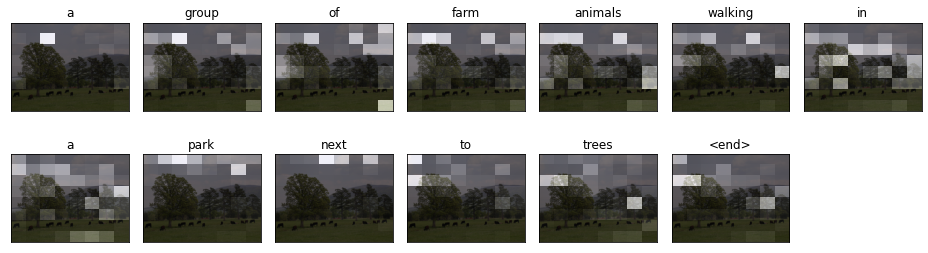


Time taken for eval 5.61 sec

Train_loss
Epoch 14 Batch 0 Loss 0.5179
Epoch 14 Batch 100 Loss 0.4722
Epoch 14 Batch 200 Loss 0.4582
Epoch 14 Batch 300 Loss 0.4586
Epoch 14 Batch 400 Loss 0.4886
Epoch 14 Batch 500 Loss 0.4550
Epoch 14 Batch 600 Loss 0.4584
Epoch 14 Batch 700 Loss 0.4826
Epoch 14 Batch 800 Loss 0.4734
Epoch 14 Batch 900 Loss 0.4742
Epoch 14 Batch 1000 Loss 0.4632
Epoch 14 Batch 1100 Loss 0.4485
Epoch 14 Batch 1200 Loss 0.4523
Epoch 14 Batch 1300 Loss 0.4787
Epoch 14 Batch 1400 Loss 0.4539
Epoch 14 Batch 1500 Loss 0.4624
Epoch 14 Batch 1600 Loss 0.4475
Epoch 14 Batch 1700 Loss 0.4548
Epoch 14 Batch 1800 Loss 0.4631
Epoch 14 Batch 1900 Loss 0.4701
Epoch 14 Batch 2000 Loss 0.4248
Epoch 14 Batch 2100 Loss 0.4945
Epoch 14 Batch 2200 Loss 0.4667
Epoch 14 Batch 2300 Loss 0.4657
Epoch 14 Batch 2400 Loss 0.4570
Epoch 14 Batch 2500 Loss 0.4737
Epoch 14 Batch 2600 Loss 0.4191
Epoch 14 Batch 2700 Loss 0.4455
Epoch 14 Batch 2800 Loss 0.4632
Epoch 14 Batch 2900 Loss 0.4624
Epoch 14 B

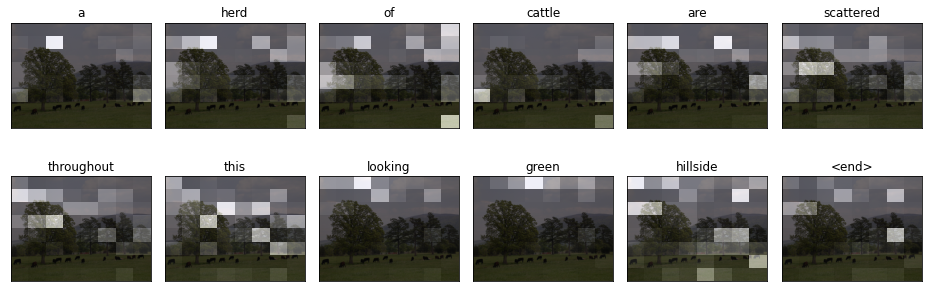


Time taken for eval 5.98 sec

Train_loss
Epoch 16 Batch 0 Loss 0.4829
Epoch 16 Batch 100 Loss 0.4620
Epoch 16 Batch 200 Loss 0.4502
Epoch 16 Batch 300 Loss 0.4834
Epoch 16 Batch 400 Loss 0.4881
Epoch 16 Batch 500 Loss 0.4569
Epoch 16 Batch 600 Loss 0.4381
Epoch 16 Batch 700 Loss 0.4782
Epoch 16 Batch 800 Loss 0.4556
Epoch 16 Batch 900 Loss 0.4452
Epoch 16 Batch 1000 Loss 0.4812
Epoch 16 Batch 1100 Loss 0.4445
Epoch 16 Batch 1200 Loss 0.4622
Epoch 16 Batch 1300 Loss 0.4333
Epoch 16 Batch 1400 Loss 0.4467
Epoch 16 Batch 1500 Loss 0.4677
Epoch 16 Batch 1600 Loss 0.4818
Epoch 16 Batch 1700 Loss 0.4351
Epoch 16 Batch 1800 Loss 0.4391
Epoch 16 Batch 1900 Loss 0.4512
Epoch 16 Batch 2000 Loss 0.4301
Epoch 16 Batch 2100 Loss 0.4385
Epoch 16 Batch 2200 Loss 0.4400
Epoch 16 Batch 2300 Loss 0.4401
Epoch 16 Batch 2400 Loss 0.4368
Epoch 16 Batch 2500 Loss 0.4885
Epoch 16 Batch 2600 Loss 0.4594
Epoch 16 Batch 2700 Loss 0.4523
Epoch 16 Batch 2800 Loss 0.4297
Epoch 16 Batch 2900 Loss 0.4534
Epoch 16 B

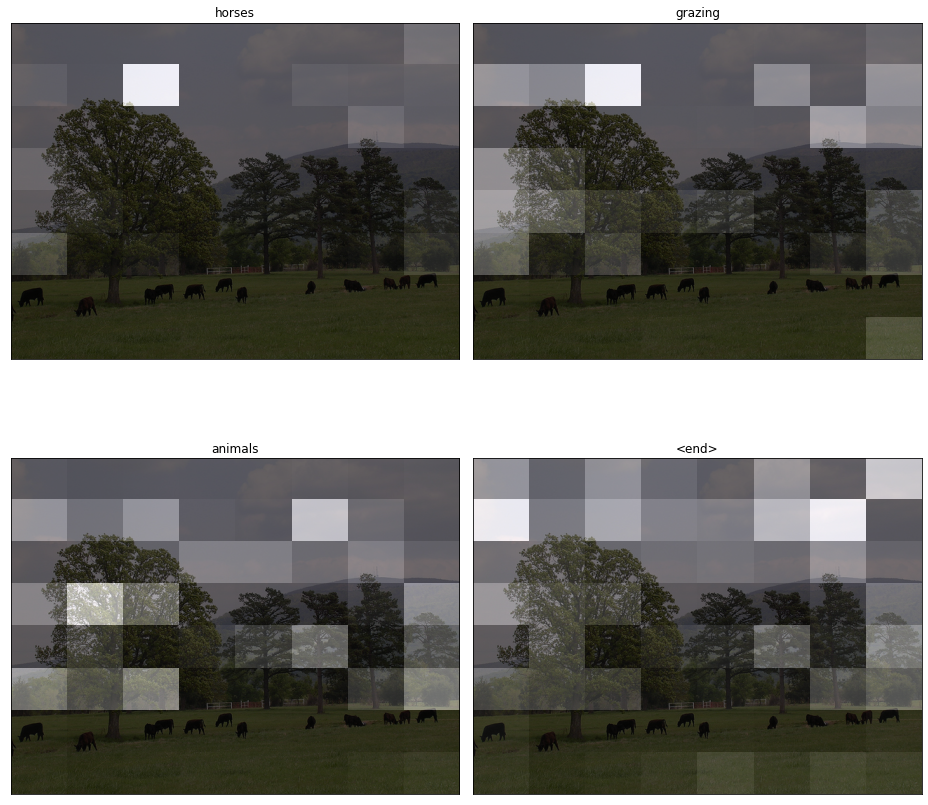


Time taken for eval 5.55 sec

Train_loss
Epoch 18 Batch 0 Loss 0.4547
Epoch 18 Batch 100 Loss 0.4256
Epoch 18 Batch 200 Loss 0.4496
Epoch 18 Batch 300 Loss 0.4298
Epoch 18 Batch 400 Loss 0.4329
Epoch 18 Batch 500 Loss 0.4343
Epoch 18 Batch 600 Loss 0.4462
Epoch 18 Batch 700 Loss 0.4331
Epoch 18 Batch 800 Loss 0.4394
Epoch 18 Batch 900 Loss 0.5028
Epoch 18 Batch 1000 Loss 0.4456
Epoch 18 Batch 1100 Loss 0.4344
Epoch 18 Batch 1200 Loss 0.4442
Epoch 18 Batch 1300 Loss 0.4475
Epoch 18 Batch 1400 Loss 0.4349
Epoch 18 Batch 1500 Loss 0.4495
Epoch 18 Batch 1600 Loss 0.4384
Epoch 18 Batch 1700 Loss 0.4405
Epoch 18 Batch 1800 Loss 0.4541
Epoch 18 Batch 1900 Loss 0.4604
Epoch 18 Batch 2000 Loss 0.4235
Epoch 18 Batch 2100 Loss 0.4054
Epoch 18 Batch 2200 Loss 0.4400
Epoch 18 Batch 2300 Loss 0.4588
Epoch 18 Batch 2400 Loss 0.4249
Epoch 18 Batch 2500 Loss 0.4519
Epoch 18 Batch 2600 Loss 0.4489
Epoch 18 Batch 2700 Loss 0.4679
Epoch 18 Batch 2800 Loss 0.4549
Epoch 18 Batch 2900 Loss 0.4902
Epoch 18 B

In [ ]:
# batch_size = 128
# img = 40000 / 128 = 321
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start_train = time.time()
    total_loss = 0

    print("Train_loss")
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)


      
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start_train:.2f} sec\n')

    ## validation 
    start_validation = time.time()
    print("Validation loss")
    for (batch, (img_tensor, target)) in enumerate(v_dataset):
        batch_loss, t_loss = loss_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
          average_batch_loss = batch_loss.numpy()/int(target.shape[1])
          print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    v_loss_plot.append(float(total_loss / v_num_steps))

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start_validation:.2f} sec\n')

    # 2 epoch마다 checkpoint 저장 
    if (epoch % 2 == 0) and (epoch !=0):
      ckpt_manager.save()

      # local drive에 저장
      copy_checkpoint_local()

      # 확인용 결과 출력
      display_attention_caption()

      # 평가 지표 계산(매번하면 이것도 너무 오래 걸림)
      start_eval = time.time()
      blue_score, cosin_score = score_fuction()
      blue_score_plot.append(blue_score)
      cosin_score_plot.append(cosin_score)

      print(f'Time taken for eval {time.time()-start_eval:.2f} sec\n')


learing_curve(loss_plot, v_loss_plot)
blue_cos_score(blue_score_plot, cosin_score_plot)

In [50]:
tf.saved_model.save(attention, 'save_dee')

NameError: ignored

In [39]:
## 이부분은 출력과 결과 스코어 계산을 위한 부분


from tqdm.notebook import tqdm
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def l1_normalize(v): #각 벡터안의 요소값을 모두 더한 것의 크기가 1이 되도록 벡터의 크기를 조절하는 방법
    norm = np.sum(v)
    return v / norm
    
    
def print_caption(): 
    cosin_list=[]
    euclidean_list=[]
    manhattan_list=[]
    ref1=[]
    ref=[]
    hyp=[]
    for j in tqdm(range(len(img_name_val))):
        image = img_name_val[j]
        t=[tokenizer.index_word[i] for i in cap_val[j] if i not in [0]]
        real_caption = t[1:-1]
        ref.append(' '.join(real_caption))

        if (j+1)% 5 == 0 :
            result, attention_plot = evaluate(image)
            hyp.append(' '.join(result[:-1]))
            ref1.append(ref)
            ref=[]
            
    a=bleuscore(ref1,hyp)
    for count,j in tqdm(enumerate(ref1)):
        matrix=j
        matrix.append(hyp[count])
        matrix=np.array(matrix)
        tfidf_matrix=vectorizer(matrix) #5개의 캡셔닝 정답문장

        tfidf_norm_l1 = l1_normalize(tfidf_matrix) # L1 정규화  
        yr=tfidf_norm_l1[0:5]
        for i in yr:
            cosin=float(cosine_similarity(tfidf_norm_l1[5], i))
            euclidean=float(euclidean_distances(tfidf_norm_l1[5], i))
            manhattan=float(manhattan_distances(tfidf_norm_l1[5], i))
            cosin_list.append(cosin)
            euclidean_list.append(euclidean)
            manhattan_list.append(manhattan)
        #return_Dict={"1_gram_bleu":a[0],"2_gram_bleu":a[1],"3_gram_bleu":a[2],"4_gram_bleu":a[3],"1~3_gram_bleu":a[4],"Jaccard":Jaccard,
         #            "cosin":np.mean(cosin_list),"euclidean":np.mean(euclidean_list),"manhattan":np.mean(manhattan_list)}
    a.append(np.mean(cosin_list))
    a.append(np.mean(euclidean_list))
    a.append(np.mean(manhattan_list))
    
    print(a)
    return a

def vectorizer(a):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(a)
    return tfidf_matrix

def bleuscore(ref,hyp):
    spacy_eng = spacy.load("en")
    jaccard=[]
    gram1_mean=[]
    gram2_mean=[]
    gram3_mean=[]
    gram4_mean=[]
    gram_13_mean=[]
    count=0
    smoothie = SmoothingFunction().method5
    for count,a in tqdm(enumerate(ref)):
        result1=hyp[count] 
        c=[]
        for i in a:
            b=[tok.text.lower() for tok in spacy_eng.tokenizer(i)]
            c.append(b)
        result=[tok.text.lower() for tok in spacy_eng.tokenizer(result1)]
        bleu_1gram = sentence_bleu(c,result, weights=(1, 0, 0, 0))
        bleu_2gram = sentence_bleu(c,result, weights=(0, 1, 0, 0),smoothing_function=smoothie)
        bleu_3gram = sentence_bleu(c,result, weights=(0, 0, 1, 0),smoothing_function=smoothie)
        bleu_4gram = sentence_bleu(c,result, weights=(0, 0, 0, 1),smoothing_function=smoothie)
        bleu_cum1 = sentence_bleu(c, result, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

        if(count==399):
            print(c)
            print(result)
        gram1_mean.append(bleu_1gram)
        gram2_mean.append(bleu_2gram)
        gram3_mean.append(bleu_3gram)
        gram4_mean.append(bleu_4gram)
        gram_13_mean.append(bleu_cum1)
        count+=1
        m=0
        for i in c: #자카드 유사도
            union = set(i).union(set(result))
            intersection = set(i).intersection(set(result)) 
            Jaccard= len(intersection)/len(union)
            if(m<Jaccard): #가장 유사도가 높은 문장끼리 매칭을 시켜 유사율을 반환
                m=Jaccard
        jaccard.append(m)
                    
    a=[np.mean(gram1_mean),np.mean(gram2_mean),np.mean(gram3_mean),np.mean(gram4_mean),np.mean(gram_13_mean),np.mean(jaccard)]
    
    
    return a

In [217]:
path = Path('.')
[i for i in path.iterdir() if '.jpg' in str(i)]

[PosixPath('COCO_train2014_000000000562.jpg'),
 PosixPath('COCO_train2014_000000000514.jpg'),
 PosixPath('COCO_train2014_000000000572.jpg'),
 PosixPath('COCO_train2014_000000000529.jpg'),
 PosixPath('COCO_train2014_000000000540.jpg')]

In [ ]:
from IPython.display import Image as imga
import pandas as pd
start_epoch=0
EPOCHS = 10
a1=[]
a2=[]
a3=[]
a4=[]
mean_gram=[]
low=[]
high=[]
jaccard=[]
cosin=[]
euclidean=[]
manhattan=[]

def print_examples():
    # path = "/home/seeds/iconms12/tmp/Image_cap/Test_img/"
    # img_file = os.listdir(path)
    # img_names = [file for file in img_file if file.endswith(".jpg")]
    path = Path('.')
    img_names = [i for i in path.iterdir() if '.jpg' in str(i)]
    for i in img_names:
        image=str(i)
        display(imga(filename=image, width=300,height=200))
        result, attention_plot = evaluate(image)
        print ('Prediction Caption:', ' '.join(result[:-1]))
        
for epoch in range(start_epoch, EPOCHS):
    
    
    print(epoch)
    print_examples()
    
    start = time.time()
    total_loss = 0
    print("Train_loss")
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(float(total_loss / num_steps))
    
    ckpt_manager.save() #2epoch마다 체크포인트 저장

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
      #val
    print("Validation loss")
    for (batch, (img_tensor, target)) in enumerate(v_dataset):
        batch_loss, t_loss = loss_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    v_loss_plot.append(float(total_loss / v_num_steps))

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/v_num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    h=print_caption()
    a1.append(f'{h[0]:.3f}')
    a2.append(f'{h[1]:.3f}')
    a3.append(f'{h[2]:.3f}')
    a4.append(f'{h[3]:.3f}')
    mean_gram.append(f'{h[4]:.3f}')
    jaccard.append(f'{h[5]:.3f}')
    cosin.append(f'{h[6]:.3f}')
    euclidean.append(f'{h[7]:.3f}')
    manhattan.append(f'{h[8]:.3f}')
    

dic={'epoch':range(1, EPOCHS+1),'val_loss':v_loss_plot,'train_loss':loss_plot,'1-gram' : a1,'2-gram' : a2,'3-gram' : a3,'4-gram' : a4,
'1-3 gram' : mean_gram, "jaccard":jaccard, "cosin":cosin, "manhattan":manhattan, "euclidean":euclidean}
#dic={'train_loss':loss_plot}
#dic={'epoch':range(1, EPOCHS+1),'val_loss':v_loss_plot,'train_loss':loss_plot}
b=pd.DataFrame(dic)
b.to_csv("final_model_trained.csv", mode='w', header=True)